![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/Baniere.png)

# Case study study

*Written by Marc Budinger, INSA Toulouse, France*

Your objective is to specify the hybrid storage system of an electric bus for doubling line 78 between the IUT Rangueil and MFJA stations.

We will :
- generate mission profiles corresponding to a new need for an urban transport line
- optimize certain mission profiles choices to minimize consumption
- size super-capacitors and battery for a given application

In order to have flexibility in the definition of the case studies, an object-oriented programming approach will be used.

### Bluebus vehicles

We can define a general vehicle class wich can represent the multiple possible supports.

In [7]:
class vehicle:
    def __init__(self, MaxSpeed, MaxAcc,NumberPass,Weight,Crr,Cd,FrontArea):
        self.MaxSpeed = MaxSpeed # [m/s] maximal speed
        self.MaxAcc = MaxAcc # [m/s²] maximal acceleration
        self.NumberPass = NumberPass # [-] passenger capacity (3p/m²)
        self.Weight = Weight # [kg] effective weight (with passenger 62kg/p)
        self.Crr = Crr # [-] rolling resistance coefficient
        self.Cd = Cd # [-] drag coefficient
        self.FrontArea = FrontArea # [m²] frontal area
        self.Fmax = Weight*MaxAcc # [N] max traction force
        self.Pmax = self.Fmax*self.MaxSpeed # [W] max corner power


Here you will find the bluebus  The characteristics of the bus are [here](https://www.bluebus.fr/sites/bluebus/files/medias/images/PDF/bluebus_6_m_fiche_technique.pdf) :

| Attribute  |  Blue Bus |
|---    |:-:    |
| Maximum operational speed     |  70 km/h     |  
| Acceleration and braking      | 1.2 m/s²      | 
| Passenger capacity       | 35     |
| Vehicle effective weight | 8300 kg |
| Rolling resistance coefficient | 0.015 |
| Aerodynamic drag coefficient| 0.6 |
| Frontal area | 6.5 m² |



We define 1 instancesof the  class `vehicle` corresponding to the vehicle above.

In [8]:
Bus = vehicle(70*1e3/3600,1.2,35,8300,0.015,0.6,6.5)


### Generation and mission profile simulation

The objective now is to simulate the dynamic evolution of the main mechanical quantities (position, speed, acceleration, tractive effort, driving power) on typical sections of urban routes.

When a vehicle travels from point A (Starting point) to point B (Stopping point ) it generally passes through four stages namely:
- Accelerating mode
- Constant speed mode
- Coasting mode
- Braking mode

The control points for switching from one mode to another are defined in the following code using 3 parameters $k_1, k_2, k_3$ as shown in the figure below. 
![General Speed Profile](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/GeneralspeedProfile.PNG)

The following code implements a control logic comprising the 4 phases defined previously and a numerical integration of the differential equation corresponding to the longitudinal dynamics of the vehicle.


In [9]:
import numpy as np
from scipy import signal
from scipy.optimize import fmin_slsqp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class SimulSection:
    def __init__(self,Vehicle,Distance, MeanSpeed,BrakeRatioMax,dt):
        # Parameters definition
        self.Vehicle = Vehicle # vehicle parameters
        self.Distance = Distance # [m] distance to travel
        self.MeanSpeed = MeanSpeed # [m/s] Mean Speed < MaxSpeep
        self.TravelTime = self.Distance / self.MeanSpeed  # [s] Travel time
        self.BrakeRatioMax = BrakeRatioMax # [-], inferieur à 1, ratio de puissance de freinage / Puisssance d'acceleration
        self.rho = 1.25 # [kg/m3] air density
        self.g = 9.81 # [m/s²] gravity
        self.dt = dt # Time step for numerical solver
        
        # Tests sur les lois de mouvement
        # https://fr.wikipedia.org/wiki/Loi_de_mouvement
        
        if (MeanSpeed>=Vehicle.MaxSpeed):
           print("Mean Speed is to high : Mean Speed > Vehicle Max Speed") 
        
        # profil triangulaire : minimise l'acceleration
        #     amax = 4⋅xf/T2 ;    vmax = 2⋅xf/T ; amax = vmax / (T/2) ; vmean = vmax / 2
        #     amax = 4*vmean^2 / xf
        
        # Calcul de l'acceleration possible a pleine vitesse
        AmaxFullSpeed=(self.Vehicle.Fmax - 1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*self.Vehicle.MaxSpeed**2 - self.Vehicle.Weight*self.g*self.Vehicle.Crr)/self.Vehicle.Weight
        if (AmaxFullSpeed < 4*self.MeanSpeed / self.TravelTime):
            print("Vehicle Max Acceleration (depending of max force) is too low or travel distance too small or mean speed too small")
            
            
    # dynamic model for acceleration, coasting and braking
    def model(self, y,F):
        # state
        x, dxdt = y
        # System: acceleration calculation
        dxdt2 = (F-self.Vehicle.Crr*self.Vehicle.Weight*self.g*np.sign(dxdt)
                 -1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*dxdt**2**np.sign(dxdt))/self.Vehicle.Weight
        dydt = [dxdt, dxdt2]
        return dydt 

  
    # https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html
    # solver numerique
        
    def solver(self, x):
        k1, k2, k3 = x
        dt=self.dt # [s] pas de temps pour l'integration
        t=0
        self.tsection = [0]
        self.xsection = [0]
        self.vsection = [0]
        self.asection = [0] 
        self.psection = [0]
        self.Fsection = [0]
        self.NRJsection = [0]
        NRJ=0
        
        y0 = np.array([0, 0]) 
        y= y0
        
      
        while (y[1]>=0):
            # Traction/Braking force
            if (y[0]<k1*k2*k3*self.Distance):
                F=self.Vehicle.Fmax
                dydt = self.model(y, F)
            elif (y[0]<k3*k2*self.Distance):
                F=self.Vehicle.Crr*self.Vehicle.Weight*self.g+1/2*self.rho*self.Vehicle.Cd*self.Vehicle.FrontArea*y[1]**2
                dydt = [y[1], 0]
            elif (y[0]<k3*self.Distance):
                F=0
                dydt = self.model(y, F)
            else:
                F=-self.Vehicle.Fmax
                dydt = self.model(y, F)
                
            self.Fsection = self.Fsection + [F]    
                
            # Euler integration de la postion y[0] et de la vitesse y[1]
            y = y + dt * np.array(dydt)

            t = t + dt
            NRJ = NRJ+y[1]*F*dt

           
            self.tsection = self.tsection + [t]
            self.xsection = self.xsection + [y[0]]
            self.vsection = self.vsection + [y[1]]
            self.psection = self.psection + [y[1]*F]
            self.asection = self.asection + [dydt[1]] 
            self.NRJsection = self.NRJsection + [NRJ]
            
    
    def plot(self):
        fig, axs = plt.subplots(3,2)
        axs[0,0].plot(self.tsection,self.xsection,'b-',label='Simulation')
        axs[0,0].plot(self.tsection,self.Distance*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[0,0].set_ylabel("Position (m)")
        axs[0,0].legend()
        axs[0,0].grid()
        axs[1,0].plot(self.tsection,self.vsection,'b-', label='Simulation')
        axs[1,0].plot(self.tsection,self.MeanSpeed*np.ones(len(self.tsection)),'g-',label='Specification')
        axs[1,0].plot(self.tsection,np.mean(self.vsection)*np.ones(len(self.tsection)),'r--',label='Mean')
        axs[1,0].set_ylabel("Speed (m/s)")
        #axs[1].sharex(axs[0])
        axs[1,0].grid()    
        axs[1,0].set_xlabel('Time (s)')    
        axs[0,1].plot(self.tsection,self.Fsection,'b-')
        axs[0,1].set_ylabel("Force (N)")
        axs[0,1].grid()
        
        axs[2,0].plot(self.tsection,self.asection,'b-')
        axs[2,0].set_ylabel("Acceleration (m/s²)")
        axs[2,0].grid()
        axs[2,0].set_xlabel('Time (s)')    
        
        axs[1,1].plot(self.tsection,np.array(self.psection)*1e-3,'b-')
        axs[1,1].set_ylabel("Power (kW)")
        axs[1,1].grid()
        axs[1,1].set_xlabel('Time (s)')   
        
        axs[2,1].plot(self.tsection,np.array(self.NRJsection)*1e-3,'b-')
        axs[2,1].set_ylabel("Energy (kJ)")
        axs[2,1].grid()
        axs[2,1].set_xlabel('Time (s)') 
        fig.tight_layout()

    def ConsumptionPerPax(self,x):
        Trajet.solver(x)
        print("Consumption per passenger: %.2f kJ/(Pax.km)"%(Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance))
        return (Trajet.NRJsection[-1]/Trajet.Vehicle.NumberPass/Trajet.Distance) 
    


Example of use of the previous code:

Mean Speed is to high : Mean Speed > Vehicle Max Speed
Vehicle Max Acceleration (depending of max force) is too low or travel distance too small or mean speed too small
Consumption per passenger: 26.76 kJ/(Pax.km)


26.755558445417467

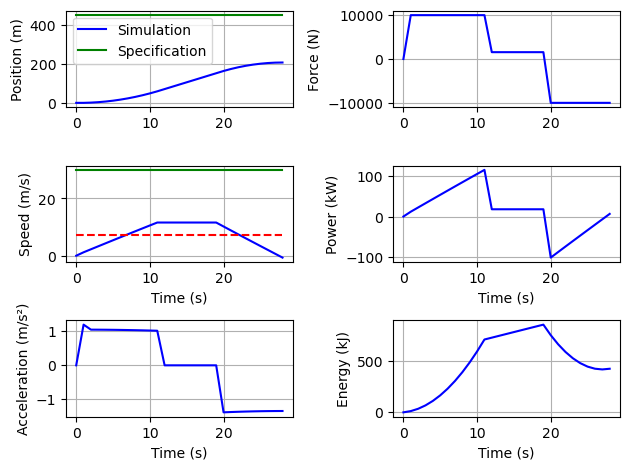

In [10]:
# Definition of the section under study
Trajet = SimulSection(Vehicle=Bus, Distance=450, MeanSpeed=30,BrakeRatioMax=0.6,dt=1)

# Definition of k1, k2, k3 parameters
#X=[0.036125972011676784, 1, 0.9638740279883232]
X=[0.33, 1, 0.33]

# Profile integration, plotting and consummption per passenger evaluation
Trajet.solver(X)
Trajet.plot()
Trajet.ConsumptionPerPax(X)

A extrema case is a triangular profile without constant speed and coasting modes which minimizes acceleration and inertial driving force.
> **Question:** Give the relationship between acceleration, average speed and distance traveled if we assume the acceleration and braking phases are perfectly linear.


### Optimizing power consumption using speed profile

In a more general case and contrary to the previous hypothesis, the braking power is not necessarily identical to that possible during acceleration. The following article shows that it is possible to optimize the consumption of a tram:
> Tian, Z., Zhao, N., Hillmansen, S., Roberts, C., Dowens, T., & Kerr, C. (2019). SmartDrive: Traction energy optimization and applications in rail systems. IEEE Transactions on Intelligent Transportation Systems, 20(7), 2764-2773.

The previous class is now extended to allow optimization of variables $k_1, k_2, k_3$ in order to minimize energy consumption (even with braking power lower than acceleration power).

In [11]:
class OptimSection(SimulSection):   
    # Gradient optimization
    def objectif(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        return (self.NRJsection[-1]/NRJmin)
                
    def contraintes(self, x):
        self.solver(x)
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        print(PowerAccBrakeRatio)
        # contraintes en distance, vitesse moyenne (ou duree de trajet, vitesse au freinage), ratio puissance freinage / acc 
        return [(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, 
                self.BrakeRatioMax-PowerAccBrakeRatio ]    
      
    
    def optimize(self,x0):
        
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,.99)]
        
        Xopt=fmin_slsqp(func=self.objectif, x0=x0, f_ieqcons = self.contraintes, bounds=Xbound, epsilon=1e-2)
                
        return Xopt
    
    # Differential evolution optimization
    
    def objectifG(self, x):
        self.solver(x)
        NRJmin = self.xsection[-1]*self.Vehicle.Weight*self.g*self.Vehicle.Crr
        pen=0
        TimeTrajet = self.Distance / self.MeanSpeed  
        PowerAccBrakeRatio = abs(min(self.psection))/max(self.psection)
        VecC=[(self.xsection[-1]-self.Distance)/self.Distance, (TimeTrajet-self.tsection[-1])/TimeTrajet, self.BrakeRatioMax-PowerAccBrakeRatio ]      
        for C in VecC:
            if (C<0):
                pen=pen-1e2*C
        
        return (self.NRJsection[-1]/NRJmin+pen)
    
    
    
    def optimizeG(self,x0):
        Xbound= [(0.0, 0.3), (0.1, 1), (0.5,0.99)]
        res=differential_evolution(func=self.objectifG, x0=x0, bounds=Xbound)
        print(res)
        return res.x
    


The usage of the class is quite simular that the previous one, except an `optimize`which enable to optimize the $k_1, k_2, k_3$ set of profile parameter: 

     fun: 1.228250159926261
 message: 'Optimization terminated successfully.'
    nfev: 1489
     nit: 32
 success: True
       x: array([0.28128974, 0.47221007, 0.9584055 ])
Optimal vector : [0.28128974 0.47221007 0.9584055 ]
0.587352478030885
Constraints vector : [0.0007887116533328885, -1.3158198810372227e-16, 0.012647521969115005]
Consumption per passenger: 42.89 kJ/(Pax.km)


42.8942957567281

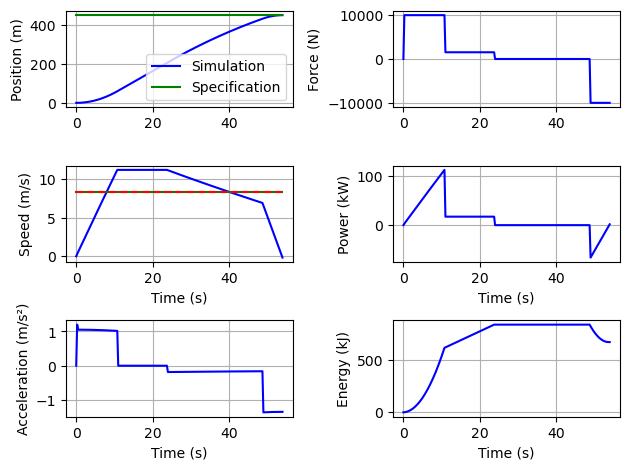

In [12]:
# Definition of the section under study
Trajet = OptimSection(Vehicle=Bus, Distance=450, MeanSpeed=30*1e3/3600,BrakeRatioMax=0.6,dt=0.25)

# Initial variables vector
X=[0.036125972011676784, 1, 0.9638740279883232]

# Optimization
Xopt=Trajet.optimizeG(X) # Global optimization with differential evolution algorithm

# Xopt=Trajet.optimize(X) # Opitmization with gradient algorithm

# print and plot results
print("Optimal vector :",Xopt)
print("Constraints vector :", Trajet.contraintes(Xopt))

Trajet.solver(Xopt)
Trajet.plot()
Trajet.ConsumptionPerPax(Xopt)

### Simulation of a complete line



In [13]:
 
from scipy import signal

class line():
    def __init__(self,Vehicle, Distances,Speeds, Chargers, StopDuration, RatioBrakeMax):
        i=0
        self.Section=[]
        self.Chargers =  Chargers # Boolean vector (True = Charger, False = No Charger , at end of te section)
        self.StopDuration = StopDuration # [s] station stop duration (scalar)
        self.RatioBrakeMax = RatioBrakeMax # [-] Ratio between max braking power / max acceleration power
        
        # initialization of  transient evolution (vectors)
        self.PowerStorage= [] # Transient evolution of requested power
        self.GlobalTime=[] # Time vector for plot and energy integration
        self.GlobalNRJStorage=[] # Transient evolution of energy
        self.PowerLF = [] # Transient evolution of power  (Low Frequency)
        self.PowerHF = [] # Transient evolution of power  (high Frequency)
        self.LFNRJStorage=[] # Time vector for plot and energy integration (Low Frequency)
        self.HFNRJStorage=[] # Time vector for plot and energy integration (High Frequency)

        self.TotalLineDistance =  sum(Distances)
        self.dt=0.25 # Time step for numerical integration
        
        # print characteristic of each section
        for d,s,c in zip(Distances,Speeds,Chargers):
            print("Section %.i: %.i m at %.2f m/s %s charger"%(i+1,d,s, "whith" if c else "without"))
            self.Section=self.Section+[OptimSection(Vehicle,d,s,self.RatioBrakeMax,self.dt)]
            i=i+1
    
    # Optimization loop of each section of the line
    def optimLine(self):
        X=[0.1,1,0.9]
        for i in range(len(self.Section)):
            self.Section[i].optimizeG(X)
            self.Section[i].plot()   
    
    # Power vector concatenation 
    def CalculPowerStorage(self):
        NRJ = 0
        self.PowerStorage= []
        self.GlobalTime= []
        dt=self.dt # [s] pas de temps pour l'integration
        
        # Power vector build thanks concatenation 
        for i in range(len(self.Section)):
            print(i)
            NRJ=NRJ+self.Section[i].NRJsection[-1] # we add here the energy consummed on the section
            
            self.PowerStorage = self.PowerStorage + self.Section[i].psection
            
            # Chargers effect
            if (self.Chargers[i] == True and i<(len(self.Section)-1)):
                tcharge=NRJ/self.Section[i].Vehicle.Pmax # Charging time caculation function of energy  
            else:
                tcharge=0
            if (tcharge>=self.StopDuration):
                self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                NRJ=0
            else:
                if (i<(len(self.Section)-1)):
                    self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                    self.PowerStorage = self.PowerStorage + [0]*int((self.StopDuration-tcharge)/dt)
                if (self.Chargers[i] == True) :
                    NRJ=0  
        
        # Time vector
        t=0
        for i in range(len(self.PowerStorage)):
            self.GlobalTime = self.GlobalTime + [t]
            t = t + dt
            
    # Filtering of total power in order to generate LF and HF pwoers
    def FilterPower(self, omega):
        TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])
        time, self.PowerLF, state = signal.lsim(TF, self.PowerStorage , self.GlobalTime)
        self.PowerHF = self.PowerStorage -  self.PowerLF
        
    # NRJ vector integration from power vectors
    def IntegrateNRJ(self):
        t=0
        NRJtotal=0
        NRJHF=0
        NRJLF=0
        #NRJTotalAging=0
        #NRJLFAging=0
        self.HFNRJStorage = []
        self.GlobalNRJStorage = []
        self.LFNRJStorage = []
        dt=self.dt
        
        for i in range(len(self.PowerStorage)):
            self.GlobalNRJStorage = self.GlobalNRJStorage + [NRJtotal]
            self.HFNRJStorage = self.HFNRJStorage + [NRJHF]
            self.LFNRJStorage = self.LFNRJStorage + [NRJLF]
            #self.TotalNRJAging = self.TotalNRJAging + [NRJTotalAging]
            #self.LFNRJAging = self.LFNRJAging + [NRJLFAging]
        
            t = t + dt
            NRJtotal = NRJtotal+(self.PowerStorage[i])*dt
            NRJHF = NRJHF+(self.PowerHF[i])*dt
            NRJLF = NRJLF+(self.PowerLF[i])*dt
        
        PmaxHF = max(abs(min(self.PowerHF)),max(self.PowerHF))/1e3 # kW
        PmaxLF = max(self.PowerLF)/1e3 # kW 
        PmaxBrakeLF = abs(min(self.PowerLF))/1e3 # kW, Max power braking
        NRJHF = (max(self.HFNRJStorage) - min(self.HFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLF = (max(self.LFNRJStorage) - min(self.LFNRJStorage))/3600/1e3 # NRJ en kWh
        
        return PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF
          
    
    
                
    # Main results plot
    def plot(self):
        fig, axs = plt.subplots(2,1)
        axs[0].plot(self.GlobalTime,self.PowerStorage,'b-',label='Total')
        axs[0].plot(self.GlobalTime,self.PowerLF,'r-.',label='LF')
        axs[0].plot(self.GlobalTime,self.PowerHF,'g-.',label='HF')
        axs[0].set_ylabel("Power (W)")
        axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[0].grid()
        axs[1].plot(self.GlobalTime,self.GlobalNRJStorage,'b-',label='Total')
        axs[1].plot(self.GlobalTime,self.LFNRJStorage,'r-.',label='LF')
        axs[1].plot(self.GlobalTime,self.HFNRJStorage,'g-.',label='HF')
        axs[1].set_ylabel("Energy (J)")
        axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[1].grid()
              
        axs[1].set_xlabel('Time (s)') 
        
        fig.tight_layout()            
        
        import pandas as pd
        df = pd.DataFrame(
            {
            "Time": self.GlobalTime,
            "TotalPower": self.PowerStorage,
            "LFPower": self.PowerLF,
            "HFPower": self.PowerHF
            }
            )
        df.to_excel('PowerData.xlsx')
            

### Example of a line definition

We can now use this new class to define a bus transport line with the following requirements:
- distances: 600, 900, 300, 450, 850 m
- mean speed: 10, 10, 8, 10, 10 m/s
- one final charger


In [14]:
L78bis=line(Bus,[600, 900, 300, 450, 850 ],[10,10,8,10,10],[False,False,False,False,True], 20, 0.6)


Section 1: 600 m at 10.00 m/s without charger
Section 2: 900 m at 10.00 m/s without charger
Section 3: 300 m at 8.00 m/s without charger
Section 4: 450 m at 10.00 m/s without charger
Section 5: 850 m at 10.00 m/s whith charger


     fun: 3.425020850652252
 message: 'Optimization terminated successfully.'
    nfev: 1039
     nit: 22
 success: True
       x: array([0.29328801, 0.48578757, 0.95189546])
     fun: 1.2666136988223575
 message: 'Optimization terminated successfully.'
    nfev: 1534
     nit: 33
 success: True
       x: array([0.10817528, 0.70728893, 0.97811913])
     fun: 17.904367711689503
 message: 'Optimization terminated successfully.'
    nfev: 949
     nit: 20
 success: True
       x: array([0.29487725, 0.47146662, 0.94422824])
     fun: 19.33320132803032
 message: 'Optimization terminated successfully.'
    nfev: 1084
     nit: 23
 success: True
       x: array([0.29753836, 0.46771545, 0.95018332])
     fun: 1.2726237235323545
 message: 'Optimization terminated successfully.'
    nfev: 1084
     nit: 23
 success: True
       x: array([0.12465575, 0.66878792, 0.975906  ])


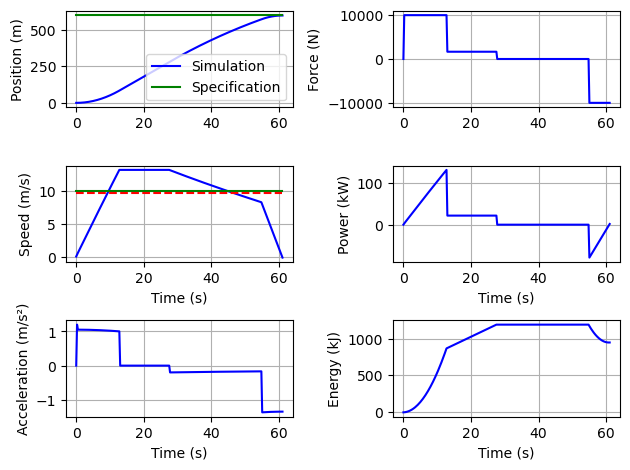

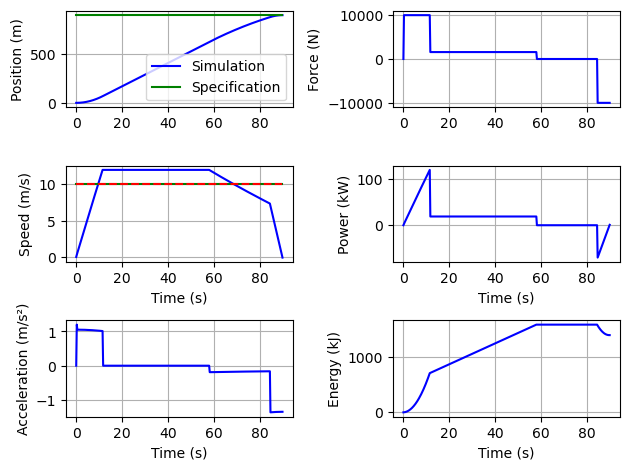

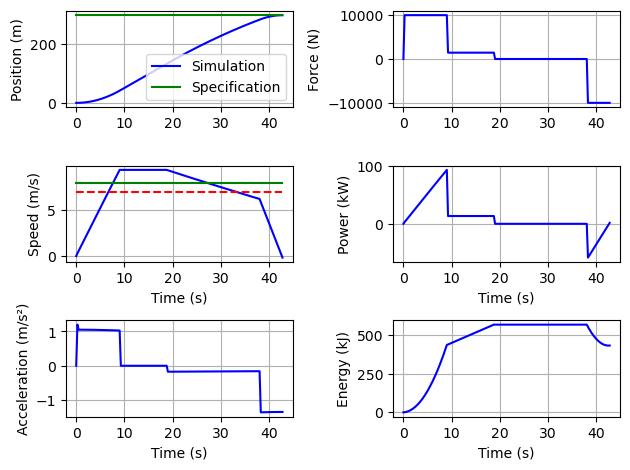

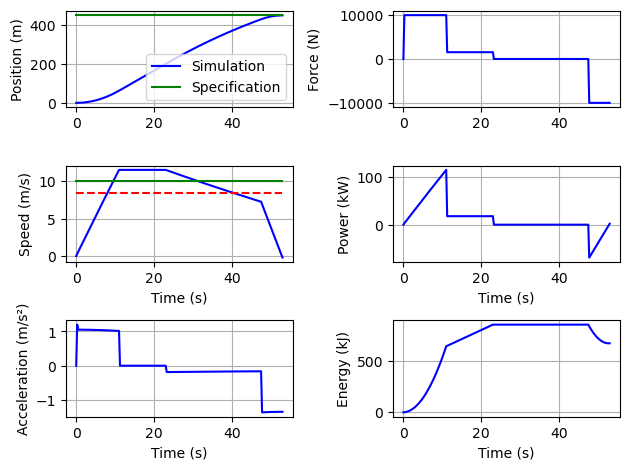

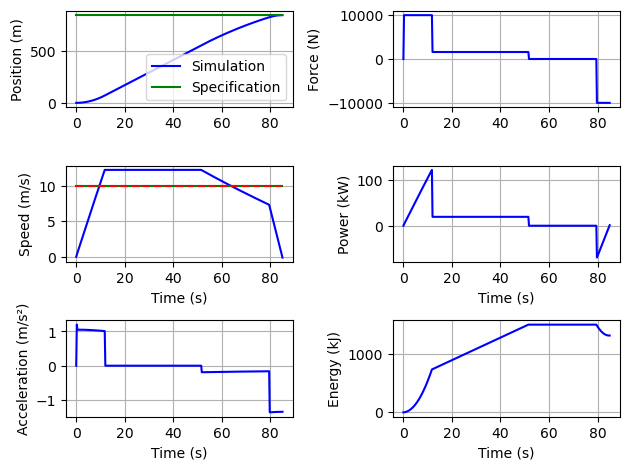

In [15]:
L78bis.optimLine()

In [16]:
L78bis.CalculPowerStorage()

0
1
2
3
4


### Hybrid storage system sizing

The energy flow or the resulting power demand will be shared between battery and supercapacity with control based on frequency sharing of demands. The Figure below show how the low frequency power will be provided by the batteries while the high frequency part will be provided by supercapacitors.

![Sizing Stategy](https://raw.githubusercontent.com/SizingLab/sizing_course/main/class/Lab-watt_project/assets/images/EnergyManagment.png)

The cutoff frequency defines the power sharing and has a strong influence on the sizing of the storage elements. The following code analyzes this power sharing by varying this cutoff frequency.

In [17]:
omegaV=np.logspace(-5,2,50)
MassStorageV=[]
MassSC=[]
MassLFPAging=[]
MassLFPNRJ=[]
MassLFPPow=[]
CO2Total=[]

# Hypothese
Targetkm = 250e3 # [km] durée de vie du vehicule

# Energie massique des supercapacités
# https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf
# chez Skeleton
WmassSC=6.8*0.75 # [Wh/kg] on suppose pouvoir recuperer 75% de l'energie stockée
PmassSC=860/4.3*6.8*0.75 # [W/kg]

# Energie massique des batteries
# LFP
WmassLFP= 100 # [Wh/kg] les LFP peuvent pratiquement etre dechargé a 100%
PmassLFP=3*100 # [W/kg]  puissance massique en decharge à 3 C
PBmassLFP=1*100 # [W/kg]  puissance massique en decharge à 1 C
Ncycle = 3000 # [-] nb de cycle de decharge a 100%

# Bilan carbone
CO2SC = 39 # kgCO2eq/kg d'ecoInvent
CO2LFP = 11 # kgCO2eq/kg d'ecoInvent

for omega in omegaV:
    L78bis.FilterPower(omega)
    PmaxHF, PmaxLF, PmaxBrake, NRJHF, NRJLF = L78bis.IntegrateNRJ()
    
    Nc=Targetkm/L78bis.TotalLineDistance # Number of cycles for global lifetime 
    DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km
    MassStorageV = MassStorageV + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)
                                   +max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)] 
    MassSC = MassSC + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)] 
    MassLFPNRJ = MassLFPNRJ + [NRJLF/WmassLFP*1e3] 
    
    MassLFPAging = MassLFPAging + [NRJLF/DoD/WmassLFP*1e3] 
    MassLFPPow = MassLFPPow + [PmaxBrake/PBmassLFP*1e3]
    CO2Total = CO2Total + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)*CO2SC+
                           max(NRJLF/DoD/WmassLFP*1e3, PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)*CO2LFP]



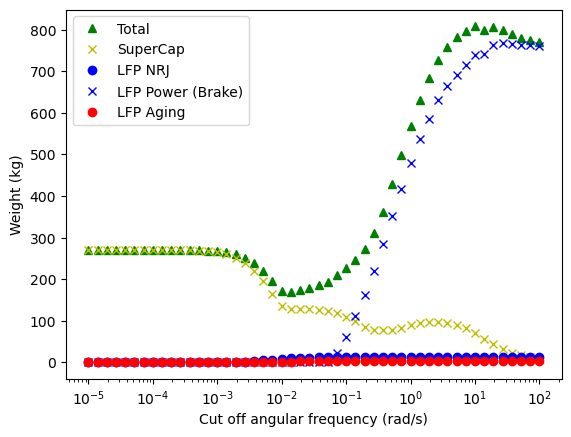

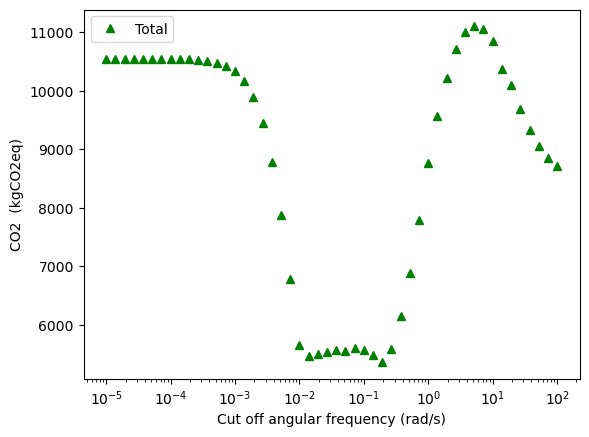

In [18]:

plt.plot(omegaV, MassStorageV, 'g^', label='Total')
plt.plot(omegaV, MassSC, 'yx', label='SuperCap')
plt.plot(omegaV, MassLFPNRJ, 'bo', label='LFP NRJ')
plt.plot(omegaV, MassLFPPow, 'bx', label='LFP Power (Brake)')
plt.plot(omegaV, MassLFPAging, 'ro', label='LFP Aging')
plt.xscale('log') 
plt.ylabel('Weight (kg)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()
plt.plot(omegaV, CO2Total, 'g^', label='Total')
plt.xscale('log') 
plt.ylabel('CO2  (kgCO2eq)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()

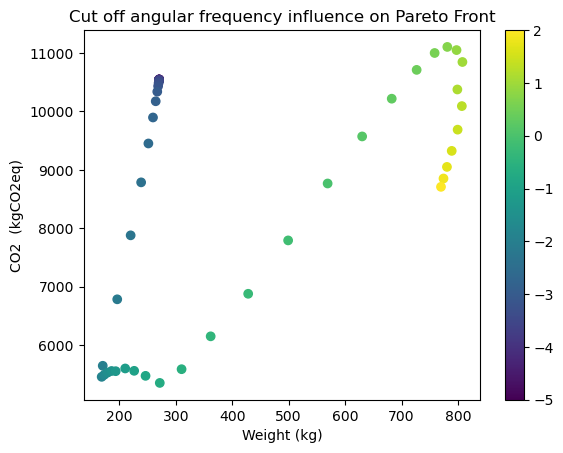

In [19]:
# Pareto Front

plt.scatter(MassStorageV, CO2Total, c=np.log10(omegaV))
plt.xlabel('Weight (kg)')
plt.ylabel('CO2  (kgCO2eq)')
plt.colorbar()
plt.title('Cut off angular frequency influence on Pareto Front')
plt.show()

Super Capacitor:
Pmax: 84.52 kW
NRJ:  0.24 kWh
Mass:  82.9 kg
---
Traction battery:
Pmax discharge: 57.50 kW
Pmax charge: 16.84 kW
NRJ : 1.38 kWh
Mass:  191.7 kg


PermissionError: [Errno 13] Permission denied: 'PowerData.xlsx'

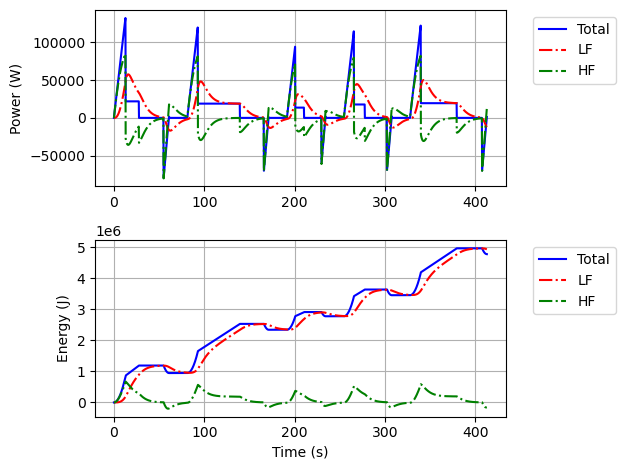

In [20]:
L78bis.FilterPower(0.2)
PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF=L78bis.IntegrateNRJ()

Nc=Targetkm/L78bis.TotalLineDistance # Number of cycles for global lifetime 
DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km

print("Super Capacitor:")
print("Pmax: %.2f kW"%PmaxHF)
print("NRJ:  %.2f kWh"%NRJHF)
print("Mass: % .1f kg"%(max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)))
      
print("---")
print("Traction battery:")
print("Pmax discharge: %.2f kW"%PmaxLF)
print("Pmax charge: %.2f kW"%PmaxBrakeLF)
print("NRJ : %.2f kWh"%max(NRJLF, NRJLF/DoD))
print("Mass: % .1f kg"%(max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrakeLF/PBmassLFP*1e3)))      

L78bis.plot()
print("---")

On prend donc :
- en supercapicté : 3 modules https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/01-DS-210831-SKELMOD-162V62F-SCH-1A.pdf associés à un hacheur de 30 kW chacun.
- 2 module de 100 kg de batterie LFP associé a 2 hacheurs de  30 kW. 

/!\ Les éléments de stockage ne sont pas forcement dimensionnés en énergie (par exemple pour les batteries la capacité en puissance de freinage joue beaucoup).
